# Computational statistics

In this talk I want to show you some exciting developments in statistics that have really taken off in the last 20 years or so. Generally speaking, the idea is to shift effort away from the analyst trying to understand the dense theory underlying classical statistics towards a 'brute force' approach using computationl power. Helpfully, this might also  reduce the fear of the analyst that they've chosen the wrong test for the problem and will be mocked by merciless statisticians :-)

<br>
<div>
<img src="./img/fear_of_stats.png" width="500"/>
</div>

**Fig. 1** 'The only thing we have to fear is fear of stats itself...' (copyright Robert Gerwien 2019)

* The idea has a long history: R. A. Fisher came up with the idea of the 'exact permutation test' (a manual method closely related to algorithms we'll see below) in the 1930s, but it was feasible at that time only for $2 \times 2$ contingency tables. Now we can handle much larger problems! 
* Bradley Efron wrote the paper that truly launched the field in 1979 (_'Bootstrap Methods: Another Look at the Jackknife'_), but it was built upon earlier work by Quenouille and Tukey on a method called the 'jacknife' (or 'leave-one-out' estimator). 
* John Tukey was himself a giant at the intersection of statistics and computer science - amongst other things he invented the boxplot, coined the term 'bit' and, with Cooley, derived the most common algorithm for the fast Fourier transform! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import pandas as pd
plt.rcParams["figure.dpi"] = 150

# Population

Population in this context refers to all the data it is possible to have that bears on a quantitative question. **We almost never have full population data in real problems**. We'll examine a data set related to anime media, treating this data set **as if it were the population**. 

In [2]:
anime = pd.read_csv("anime.csv")
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24012 entries, 0 to 24011
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           24012 non-null  int64  
 1   title                        24012 non-null  object 
 2   media_type                   24012 non-null  object 
 3   scoring                      14153 non-null  float64
 4   num_scoring_users            24012 non-null  int64  
 5   status                       24012 non-null  object 
 6   num_episodes                 24012 non-null  int64  
 7   start_date                   21160 non-null  object 
 8   end_date                     19719 non-null  object 
 9   source                       20238 non-null  object 
 10  num_list_users               24012 non-null  int64  
 11  popularity                   20538 non-null  float64
 12  num_favorites                24012 non-null  int64  
 13  rank            

In [3]:
anime.head()

,id,title,media_type,scoring,num_scoring_users,status,num_episodes,start_date,end_date,source,...,studios,synopsis,nsfw,created_at,updated_at,main_picture_medium,main_picture_large,alternative_titles_en,alternative_titles_ja,alternative_titles_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.14,1846307,finished_airing,64,2009-04-05 00:00:00,2010-07-04 00:00:00,manga,...,['Bones'],After a horrific alchemy experiment goes wrong...,white,2008-08-21 03:35:22,2022-04-18 05:06:13,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.05,1488156,finished_airing,148,2011-10-02 00:00:00,2014-09-24 00:00:00,manga,...,"['Madhouse', 'Studio Live']",Hunters devote themselves to accomplishing haz...,white,2011-07-27 08:41:39,2022-04-18 05:11:21,https://api-cdn.myanimelist.net/images/anime/1...,https://api-cdn.myanimelist.net/images/anime/1...,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,9253,Steins;Gate,tv,9.08,1240087,finished_airing,24,2011-04-06 00:00:00,2011-09-14 00:00:00,visual_novel,...,['White Fox'],Eccentric scientist Rintarou Okabe has a never...,white,2010-07-26 09:23:40,2022-05-01 21:24:42,https://api-cdn.myanimelist.net/images/anime/5...,https://api-cdn.myanimelist.net/images/anime/5...,Steins;Gate,STEINS;GATE,[]
3,21,One Piece,tv,8.65,1076776,currently_airing,0,1999-10-20 00:00:00,NaN,manga,...,['Toei Animation'],"Gol D. Roger was known as the ""Pirate King,"" t...",white,2005-11-11 01:20:50,2022-04-18 05:12:08,https://api-cdn.myanimelist.net/images/anime/6...,https://api-cdn.myanimelist.net/images/anime/6...,One Piece,ONE PIECE,['OP']
4,1535,Death Note,tv,8.62,2426765,finished_airing,37,2006-10-04 00:00:00,2007-06-27 00:00:00,manga,...,['Madhouse'],"Brutal murders, petty thefts, and senseless vi...",white,2006-10-04 03:39:19,2022-04-18 04:59:29,https://api-cdn.myanimelist.net/images/anime/9...,https://api-cdn.myanimelist.net/images/anime/9...,Death Note,デスノート,['DN']


Our first problem relates to `tv` and `movie` anime. 

> Does the mean `scoring` of the `tv` and `movie` groups differ significantly? 

Let's see a notched boxplot of the distribution. Note here that the notch shows a reasonable range (95% confidence interval) for the median.

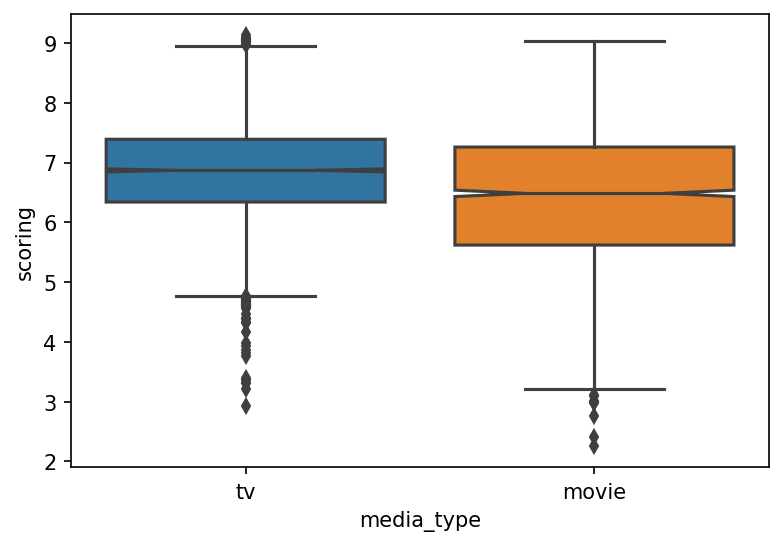

In [4]:
anime_tv_movie = anime.loc[
    anime.media_type.isin(["tv", "movie"]), :
].dropna(subset=["scoring"])

ax = sns.boxplot(x="media_type", y="scoring", data=anime_tv_movie, notch=True)

Note that there's a reasonable number of outliers (points beyond the whiskers) in each group distribution. Let's see the number of entries in each group

In [5]:
counts = anime_tv_movie.media_type.value_counts()
counts

tv       4175
movie    2282
Name: media_type, dtype: int64

and histograms of both distributions 

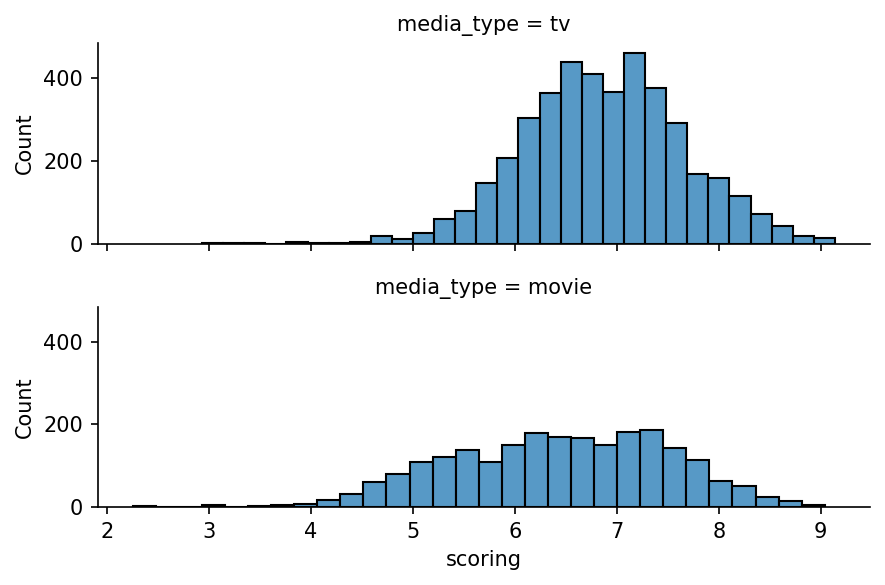

In [6]:
g = sns.FacetGrid(anime_tv_movie, row="media_type", height=2, aspect=3)
g.map(sns.histplot, "scoring", bins=30);

Note that neither distribution looks particularly normal, though they do seem unimodal.

OK, let's calculate the **population parameter**. Again, generally speaking, in real applications, we don't have access to population parameters, because we don't have access to complete populations. Inferential statistics boils down to an attempt to infer population parameters from a more limited set of data known as a **sample**

* Population $\rightarrow$ population parameter(s) (what we would like to know).
* Sample $\rightarrow$ infer sample statistic(s) (approximations for a population parameter given the limited data of the sample). 

Samples are often randomly gathered, and a huge number of samples of a given size are possible from a given population. So the question arises (and this is the fundamental question in statistics)

> 'How different might the sample statistic have been if a different sample were drawn? What is a reasonable range of sample statistics?' We call this the **sampling distribution** of a statistic.

![](img/many_samples.png)

Let's see the population parameter. Again, we won't usually have this in real applications - we'll be trying to estimate it from a sample.

In [7]:
tv_movie_diff_mean_scoring = np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "tv", "scoring"]) \
    - np.mean(anime_tv_movie.loc[anime_tv_movie.media_type == "movie", "scoring"])
tv_movie_diff_mean_scoring

0.43272950295727686

Finally, let's have a look at a measure of variation / spread in `scoring` for the two groups. Standard deviation is useful here, as it's in the same units as the original data.

In [8]:
# ddof 0 for population standard deviation
tv_movie_stdevs = anime_tv_movie \
    .groupby("media_type") \
    .scoring \
    .std(ddof=0)
tv_movie_stdevs

media_type
movie    1.063442
tv       0.795004
Name: scoring, dtype: float64

# Sampling distribution

## Samples of size 200 from each group

Let's try to answer the question above sticking to the fiction that we have access to a complete population. We'll draw lots of random samples of a given size (200 animes each from `tv` and `movie`) and calculate our statistic of interest 

<center>
$\textrm{diff means} = \overline{\textrm{scoring}}_\textrm{tv} - \overline{\textrm{scoring}}_\textrm{movie}$
</center>
    
for each sample, storing it as we go. Note that a **single sample** here consists of 200 `tv` entries **and** 200 `movie` entries.

The final collection is the **sampling distribution** for the statistic of interest (in this case, the diff in means)

In [9]:
def create_diff_means_sampling_dist(population, score_column, group_column, group_labels, group_sizes, num_resamples):
    # filter populations down to relevant groups first
    first_population_group = population.loc[
        population[group_column] == group_labels[0], score_column
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], score_column
    ]
    
    # precompute label string
    samples_sizes_string = f"({group_sizes[0]},{group_sizes[1]})"

    sampling_dist = []
    for i in range(num_resamples):
        first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
        second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        sampling_dist.append([i + 1, samples_sizes_string, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=sampling_dist, 
        columns=["resample", "sample_sizes", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [10]:
sampling_dist_diffs_200 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[200, 200], 
    num_resamples=50000
)

In [11]:
sampling_dist_diffs_200

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.89285,6.46880,0.42405
1,2,"(200,200)",6.94270,6.43795,0.50475
2,3,"(200,200)",6.90445,6.50540,0.39905
3,4,"(200,200)",6.90015,6.42630,0.47385
4,5,"(200,200)",6.80785,6.51675,0.29110
...,...,...,...,...,...
49995,49996,"(200,200)",6.90595,6.43820,0.46775
49996,49997,"(200,200)",6.84615,6.33855,0.50760
49997,49998,"(200,200)",6.84890,6.52240,0.32650
49998,49999,"(200,200)",6.87475,6.44885,0.42590


Note that the number of resamples is a setting we should worry about in a more realistic process. In general, we'd want to increase the number of resamples until some measure of the sampling distribution we're interested in converges. We'll see one of those measures below. For now let's have a look at the distribution, also plotting the population parameter as a vertical line

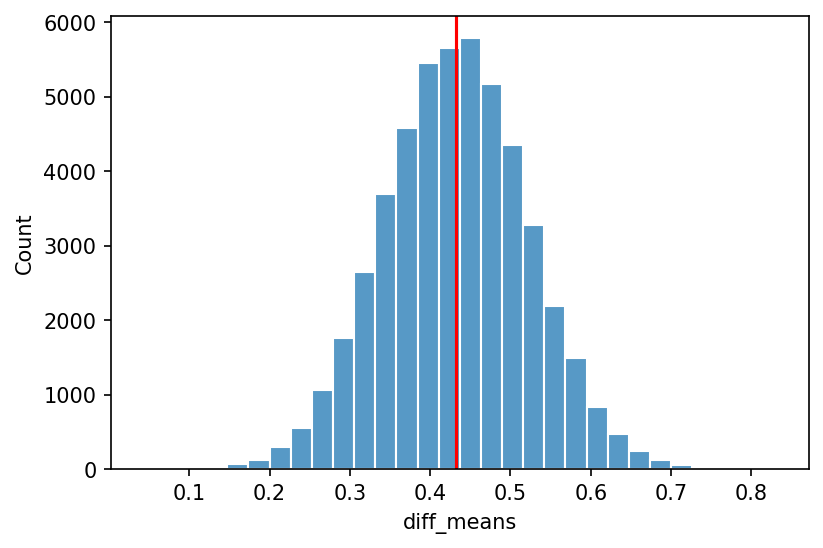

In [12]:
ax = sns.histplot(sampling_dist_diffs_200.diff_means, bins=30, edgecolor="white");
plt.axvline(tv_movie_diff_mean_scoring, 0, 1, color="red");

Note how normal this looks, even though the `scoring` distributions for `tv` and `movie` from each which statistic was calculated didn't look particularly normal. This result is called the **central limit theorem** and has been central to inferential statistics from its earliest days.

We can see a more compelling proof of the normality of the sampling distribution via a **quantile-quantile plot** - plot the quantiles of our distribution against the quantiles of the normal distribution. If the results fall on a line, the original distribution is normal.

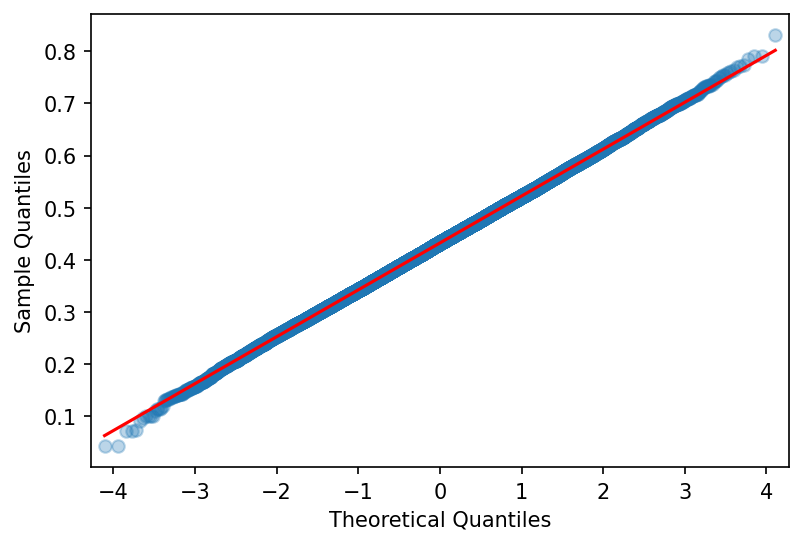

In [13]:
sm.qqplot(sampling_dist_diffs_200.diff_means, dist=norm, line="s", alpha=0.3);

Finally, here's a useful and important measure of the sampling distribution. Given we've taken lots of random samples of size 200 in each group from our population, what's a reasonable range across all samples of our statistic 

<center>
$\textrm{diff means} = \overline{\textrm{scoring}}_\textrm{tv} - \overline{\textrm{scoring}}_\textrm{movie}$
</center>
    
Let's calculate the central 95% of the distribution (i.e. calculate the 2.5% and 97.5% quantiles). What we're saying here is that we expect 95% of our random samples to generate a sample statistic within this interval.

In [14]:
interval = np.quantile(sampling_dist_diffs_200.diff_means, [0.025, 0.975])
interval

array([0.25765, 0.609  ])

And, just to remind ourselves, our population parameter is

In [15]:
tv_movie_diff_mean_scoring

0.43272950295727686

In [16]:
interval - tv_movie_diff_mean_scoring

array([-0.1750795,  0.1762705])

So the interval is approximately symmetric around the population parameter

## Samples of size 1000 from each group

What happens if we increase the sample size from each group?

In [17]:
sampling_dist_diffs_1000 = create_diff_means_sampling_dist(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type", 
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000], 
    num_resamples=50000
)

Let's deal with the data in tidy form: we'll concatenate it on the bottom of the sample size 200 dataframe from above, differentiating rows with the `sample_sizes` column 

In [18]:
sampling_dist_diffs = pd.concat([sampling_dist_diffs_200, sampling_dist_diffs_1000], axis=0, ignore_index=True)

In [19]:
sampling_dist_diffs

,resample,sample_sizes,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,"(200,200)",6.89285,6.46880,0.42405
1,2,"(200,200)",6.94270,6.43795,0.50475
2,3,"(200,200)",6.90445,6.50540,0.39905
3,4,"(200,200)",6.90015,6.42630,0.47385
4,5,"(200,200)",6.80785,6.51675,0.29110
...,...,...,...,...,...
99995,49996,"(1000,1000)",6.89485,6.42670,0.46815
99996,49997,"(1000,1000)",6.88424,6.48996,0.39428
99997,49998,"(1000,1000)",6.88979,6.45058,0.43921
99998,49999,"(1000,1000)",6.85288,6.44432,0.40856


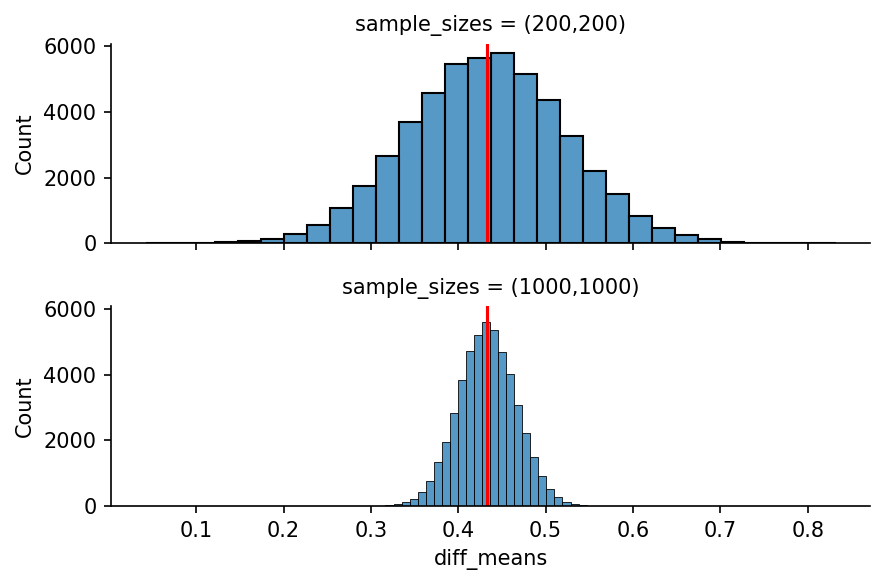

In [20]:
g = sns.FacetGrid(sampling_dist_diffs, row="sample_sizes", height=2, aspect=3)
g.map(sns.histplot, "diff_means", bins=30);
g.map(plt.axvline, x=tv_movie_diff_mean_scoring, ymin=0, ymax=1, color="red");

So we see that increasing sample size leads to a tighter distribution. This fits with our understanding that larger samples lead to lower statistical uncertainty. 

In [21]:
sampling_dist_diffs \
    .groupby("sample_sizes") \
    .diff_means \
    .agg(
        lower_interval=lambda x: np.quantile(x, 0.025),
        upper_interval=lambda x: np.quantile(x, 0.975),
        standard_error=np.std
    )

,lower_interval,upper_interval,standard_error
sample_sizes,,,
"(1000,1000)",0.36772,0.49779,0.033211
"(200,200)",0.25765,0.60900,0.089943


# Central limit theorem

Again, what we've done above is a thought exercise only! In **inferential statistics** we typically:

* don't have access to the whole population. If we did, we'd calculate the property of interest once, and that would be the end of the story (and this would fall in the remit of **descriptive statistics**)
* don't repeatedly sample from the population. Typically, we take one sample, and we make it as large as cost or practicality allow, or as we've determined necessary to provide the **statistical power** required to reliably detect the effect we're interested in

The central limit theorem tells us that the sampling distribution of the sample difference in means will be **normally distributed** (for large enough sample sizes and reasonably well-behaved population distributions), with a standard deviation given by 
  
<center>
$\sigma_{\overline{\textrm{A}}-\overline{\textrm{B}}} = \sqrt{\frac{\sigma_\textrm{A}^2}{n_\textrm{A}} + \frac{\sigma_\textrm{B}^2}{n_\textrm{B}}}$
</center>
    
where $\sigma_\textrm{A}$ and $\sigma_\textrm{B}$ are the population standard deviations of the two groups, and $n_\textrm{A}$ and $n_\textrm{B}$ are the sample sizes 

We call the standard deviation of the sampling distribution the **standard error**. The 'Galton board' or 'quincunx' is a neat mechanical representation of why normal (or near-normal) distributions are so common in the world. They tend to arise when a quantity is composed of many random contributions from lots of smaller quantities. The analogy in the quincunx is in the direction of scattering of each ball from the pegs as it falls from the hopper at the top. Assuming 10 rows of pegs, there are lots of distinct paths a ball might follow and still end up close to the center (e.g. LLRLRRLLRR, RLLRLLLRRR,...), but only one way to end up on each extreme (LLLLLLLLLL or RRRRRRRRRR). 

<br>
<div>
<img src="./img/Galton_box.jpeg" width="400"/>
</div>

**Fig. 2** Galton box by Matemateca (IME/USP)/Rodrigo Tetsuo Argenton (CC BY-SA 4.0 license)

Let's see how close our computational values are to the theory:

In [22]:
std_err_200 = np.sqrt(tv_movie_stdevs["tv"]**2/200 + tv_movie_stdevs["movie"]**2/200)
std_err_200

0.09388662752763594

In [23]:
std_err_1000 = np.sqrt(tv_movie_stdevs["tv"]**2/1000 + tv_movie_stdevs["movie"]**2/1000)
std_err_1000

0.041987376265999396

Not too bad. The importance of the CLT in the history and current practice of statistics is immense. Up until the computational methods we're going to see below became routinely possible starting around the early 90s, this theory is all that we had! Decades of inferential statistics are built on it. But there are problems: 

* What is a 'large enough' sample? People often quote $n=30$, but is that large enough in the presence of skew, outliers? Rate of convergence to normal differs for different source distributions.
* What do you do in the case that the CLT theory for the standard error of a particular statistic you are interested in is unavailable?
* A lot of the fear of statistics comes from the complexity introduced by either making sure that the CLT is applicable to your problem, or fixing it so that it is!

Enter **computational statistics and resampling**, the simpler brute force approach!

# Back to life, back to reality: a single sample...

We don't have access to the population, we don't know the population parameters. We have a single sample and we're going to use it to infer population parameters. Let's have a look at a single sample

In [24]:
def create_single_sample(population, score_column, group_column, group_labels, group_sizes):
    first_population_group = population.loc[
        population[group_column] == group_labels[0], [group_column, score_column]
    ]
    second_population_group = population.loc[
        population[group_column] == group_labels[1], [group_column, score_column]
    ]
    
    first_group_sample = first_population_group.sample(group_sizes[0], replace=False)
    second_group_sample = second_population_group.sample(group_sizes[1], replace=False)
    
    return pd.concat([first_group_sample, second_group_sample], axis=0, ignore_index=True)
    

Let's treat ourselves, and at least assume that we have access to a decently sized sample of 1000 entries each from `tv` and `movie`.

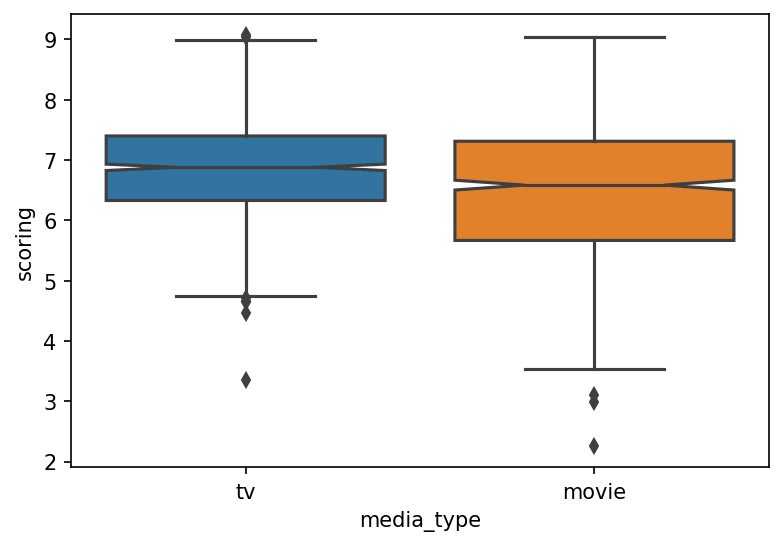

In [25]:
single_sample = create_single_sample(
    population=anime_tv_movie, 
    score_column="scoring", 
    group_column="media_type",
    group_labels=["tv", "movie"], 
    group_sizes=[1000, 1000]
)
ax = sns.boxplot(x="media_type", y="scoring", data=single_sample, notch=True)

In [26]:
single_sample

,media_type,scoring
0,tv,6.23
1,tv,6.83
2,tv,5.48
3,tv,6.66
4,tv,6.95
...,...,...
1995,movie,6.13
1996,movie,7.18
1997,movie,5.38
1998,movie,6.72


Here's our sample statistic

In [27]:
sample_statistic = np.mean(single_sample.loc[single_sample.media_type == "tv", "scoring"]) \
    - np.mean(single_sample.loc[single_sample.media_type == "movie", "scoring"])
sample_statistic

0.39206000000000074

So what do we do if we only have this one sample. This is all the data it was practical to gather, but our aim hasn't really changed. If we can get access to something approximating the sampling distribution, we can make progress. In the past, we would have used the CLT to tell us something about the sampling distribution and go ahead, with the doubts incurred about applicability, non-normality etc, but computational power now gives us another approach 

## Bootstrapping

Bootstrapping seems like magic, but it isn't really! The idea is that we generate lots of resamples from our sample by **sampling with replacement**, keeping the size of each resample the same as the original sample (this is important)

e.g.
<center>
$\textrm{sample} = {A, B, C, D, E}$
</center>
<center>
$\textrm{bootstrap1} = {E, B, C, B, A},$
</center>
<center>
$\textrm{bootstrap2} = {A, E, C, C, A},$
</center>
<center>
$\textrm{bootstrap3} = {D, B, C, A, D},$
</center>
<center>
$\textrm{bootstrap4} = {C, B, E, C, B},$
</center>
<center>
$\textrm{bootstrap5} = {B, C, C, B, C},$
</center>
<center>
and so on...
</center>

We then calculate sample statistics from each of the resamples, and use this as the sampling distribution. 

Boostrapping is based on the logic that **population is to sample as sample is to resample**. It cannot magically repair the effects of small samples or know more about your population than is known by the single sample you started with. For bootstrapping to stand a reasonable chance of working, you need to be confident that your original sample is: 

* sufficiently large
* preferrably randomly sampled
* representative of your population (stratification can help with this, e.g. if you know in your population that 40, 20 and 40% fall into groups A, B and C respectively, try to make sure proportions in your sample are similar)

In [28]:
def create_diff_means_bootstrap_dist(sample, score_column, group_column, group_labels, num_resamples):
    # pre-filter sample to groups, and get group sizes
    first_sample_group = sample.loc[
        sample[group_column] == group_labels[0], score_column
    ]
    first_sample_group_size = first_sample_group.shape[0]
    second_sample_group = sample.loc[
        sample[group_column] == group_labels[1], score_column
    ]
    second_sample_group_size = second_sample_group.shape[0]
    
    # resample from each group with replacement, calculate stat, store
    bootstrap_dist = []
    for i in range(num_resamples):
        first_group_sample = first_sample_group.sample(first_sample_group_size, replace=True)
        second_group_sample = second_sample_group.sample(second_sample_group_size, replace=False)
        
        first_group_sample_mean = first_group_sample.mean()
        second_group_sample_mean = second_group_sample.mean()
        
        this_diff = first_group_sample_mean - second_group_sample_mean
        
        bootstrap_dist.append([i + 1, \
            first_group_sample_mean, second_group_sample_mean, this_diff])
    
    return pd.DataFrame(
        data=bootstrap_dist, 
        columns=["resample", f"{group_labels[0]}_mean_{score_column}", \
            f"{group_labels[1]}_mean_{score_column}", "diff_means"]
    )

In [29]:
bootstrap_dist = create_diff_means_bootstrap_dist(
    sample=single_sample,
    score_column="scoring",
    group_column="media_type",
    group_labels=["tv", "movie"],
    num_resamples=50000
)

In [30]:
bootstrap_dist

,resample,tv_mean_scoring,movie_mean_scoring,diff_means
0,1,6.88525,6.4815,0.40375
1,2,6.85407,6.4815,0.37257
2,3,6.88351,6.4815,0.40201
3,4,6.84142,6.4815,0.35992
4,5,6.88803,6.4815,0.40653
...,...,...,...,...
49995,49996,6.87816,6.4815,0.39666
49996,49997,6.86438,6.4815,0.38288
49997,49998,6.86111,6.4815,0.37961
49998,49999,6.84995,6.4815,0.36845


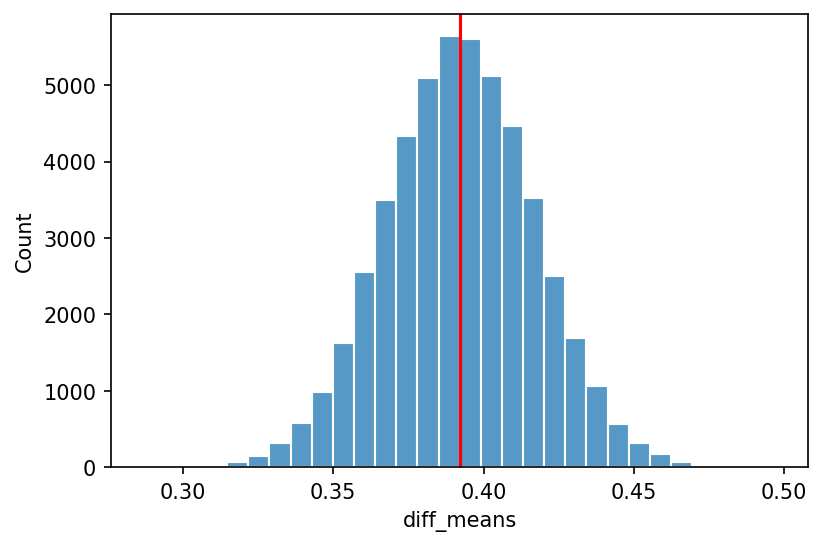

In [31]:
sns.histplot(bootstrap_dist.diff_means, bins=30, edgecolor="white");
plt.axvline(sample_statistic, 0, 1, color="red");

Looks pretty normal again, but let's check with a quantile-quantile plot

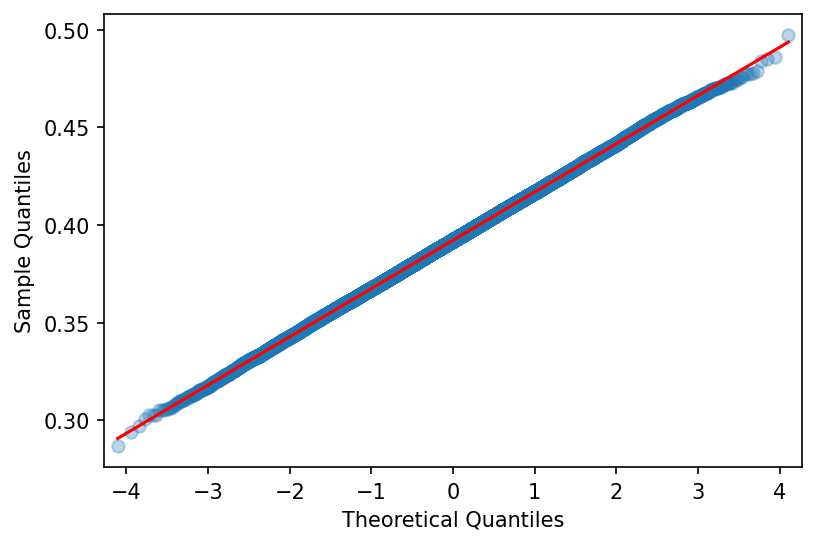

In [32]:
sm.qqplot(bootstrap_dist.diff_means, line="s", alpha=0.3);

Let's see what the bootstrapped standard error looks like

In [33]:
bootstrap_dist.diff_means.std()

0.024716516671464923

A bit lower than the value calculated by resampling from the full population, but this is to be expected given that not all of the outliers in the population `scoring` column for the `tv` and `movie` groups will have made it into the original sample, reducing variability in the mean. Again, the bootstrap isn't magic, it can only work with the sample it's given.

### Percentile CI

Let's use the bootstrapped sampling distribution to calculate confidence interval for the statistic. The simplest approach is very similar to the one we used earlier: for confidence level $C$, calculate quantiles for probabilities $\frac{1 - C}{2}$ and $\frac{1 + C}{2}$. Note that this is what we call a 'non-parametric' approach - we don't make any assumptions about the shape or form of the bootstrap sampling distribution in calculating the CI 

In [34]:
def percentile_CI(bootstrap_dist, value_column, confidence_level):
    lower_prob = (1 - confidence_level) / 2
    upper_prob = (1 + confidence_level) / 2
    return np.quantile(bootstrap_dist[value_column], [lower_prob, upper_prob])

In [35]:
percentile_CI(bootstrap_dist, "diff_means", 0.95)

array([0.34370975, 0.4406005 ])

### Bias-corrected CI

We expect the sampling distribution to be symmetrically distributed around the sample stat, but the effects of skew and outliers can sometimes shift the distribution left or right a bit. We call this shift **bias**, but we can correct for it before we calculate the CI.

Note that this is a 'parametric' approach. The presence of `norm.ppf()` in the code below tells us we're assuming that the sampling distribution is normally distributed, which you should check before using this method.

In [36]:
def bias_corrected_CI(bootstrap_dist, sample_stat, value_column, confidence_level):
    '''
    Assumes that bootstrap sampling distribution is normal and should by symmetrically distributed around the 
    sample statistic. Any deviation from latter reflects effects of bias in bootstrap distribution. CI can be 
    corrected to symmetrise distribution around sample statistic. 
    '''
    lower_prob = (1 - confidence_level) / 2
    upper_prob = (1 + confidence_level) / 2
    
    lower_z = norm.ppf(lower_prob)
    upper_z = norm.ppf(upper_prob)
    
    num_below_stat = np.sum(np.array([1 for value in bootstrap_dist[value_column] if value <= sample_stat]))
    frac_below_stat = num_below_stat / bootstrap_dist.shape[0]
    z0 = norm.ppf(frac_below_stat)
    
    corrected_lower_prob = norm.cdf(2 * z0 + lower_z)
    corrected_upper_prob = norm.cdf(2 * z0 + upper_z)
        
    return np.quantile(bootstrap_dist[value_column], [corrected_lower_prob, corrected_upper_prob])

In [37]:
bias_corrected_CI(bootstrap_dist, sample_statistic, "diff_means", 0.95)

array([0.343408  , 0.44037097])

### Interpretation of CIs

Frequentist statisticians tie themselves in philosophical knots over the interpretation of CIs. Naively, you might think that if the confidence level is say 95%, then there is 95% probability of finding the population parameter inside the calculated interval. But, from the frequentist view, this cannot be correct, as it makes it sound like it's the population parameter that is subject to uncertainty, while the data is fixed. For, frequentists, it's the other way around: they would say that the population parameter and population data are fixed (but unknown), and it's the **sampling process that introduces uncertainty**. 

Fair enough and whatever: the interpretation of a 95% CI then is the following:

* Given 100 random samples, all of the same size, drawn from the population
* We calculate a 95% CI for the statistic of interest for each sample 
* 95 of the 100 CIs would contain the population parameter
* 5 would not

Importantly, we don't know ahead of time whether our single sample is one of the lucky 95 samples or one of the unlucky 5! Frequentists encode this uncertainty by saying "we're 95% **confident** the population parameter is in the range..."

### Improving bootstrap accuracy

We don't really have time to get into them here, but more accurate bootstrap CI methods exist than the simple percentile and bias-corrected (BC) algorithms presented above. In particular, the double (or studentized) bootstrap CI offers significant improvements at the cost of increased computational complexity. 

In the latter method, we perform **nested bootstraps**: for each outer bootstrap resample we perform an inner bootstrap, typically with a much smaller number of replications of the order 10s-100s. The aim of the inner bootstrap is to estimate the standard error in the sample statistic for that particular resample. 

It's easy to appreciate that this inner loop greatly increases the computational burden, naively by a factor of the number of inner replications, but algorithms based on early stopping rules exist that aim to curb the effort required (see Nankervis 2005 https://doi.org/10.1016/j.csda.2004.05.023).  

![Variation in coverage and CI width of different bootstrap methods with sample size](img/CI_coverage_width_methods.png)
**Fig. 3**: Variation in coverage and CI width of different bootstrap methods with sample size (Bittmann 2021)

**'Coverage'**: we aim to calculate CIs at a particular confidence level, but the effect of small sample sizes and/or skew and outliers can shift confidence away from the anticipated value. The actual value achieved is termed the 'coverage'. We can estimate coverage in the following way:

1. For a given population distribution, calculate the parameter of interest.
2. Pull a random sample from the population (without replacement) of the correct size $n$.
3. Given that sample, calculate a CI for your statistic at the desired confidence level, using your algorithm of choice, making sure the algorithm is converged wrt other variables we control (number of replicates being the main one).
4. Note whether the population parameter lies within the CI.
5. Go to 2 and repeat a decent number of times, e.g. a few thousand.
6. The proportion of calculated CIs containing the population parameter is the coverage achieved for that population distribution, at that sample size, for that bootstrap algorithm.

# Hypothesis testing

## Reminder 

Typically have two **mutually exclusive** (can't both be true simultaneously) and **exhaustive** (no other options) hypotheses we are trying to decide between based on available data. Acknowledging we have choice in how we set up our hypotheses, by convention: 

* We consider the **null** hypothesis $H_0$ to be true by default. This represents the 'conservative' position (business as usual, nothing interesting is happening). In a court case, this would be the 'not guilty' verdict.
* We place the burden of proof on the **alternative** hypothesis $H_a$, which represents the 'active' position (something interesting is happening, new finding, significant change from prior behaviour). In a court case, this would be the 'guilty' verdict, which has to be actively proven (as 'not guilty' is the default judgement).

**Example - Website A/B testing** 

For a randomly sampled group of users B (perhaps stratified) show them the button in a proposed new position, while for remainder group A show them the button in old position. Gather click-through rates on the button for both groups. Try to aim for equal group sizes.

* $H_0 = \textrm{click-through rate in group B is less than or equal to rate in group A}$ 
* $H_a = \textrm{click-through rate in group B is greater than rate in group A}$
* This is an example of a 'one-tailed' test: we are interested in deviations from the null in only one direction ('...greater than...')
* If we had more than two potential button positions we could use an ANOVA style approach where we split incoming users into more than two groups. Our first hypothesis test would be determine whether 'somewhere there exists a significant difference between click-through rates amidst all the groups'. We could then conduct post-hoc tests to determine where any significant differences arise.

The outcome of the test is typically determined by calculating a $p$-value ($p$ standing for probability) and comparing it with a **significance level** $\alpha$ set by the analysts before the test was started ($p \le \alpha$ means the effect is significant). Typically, you'll see $\alpha = 0.05$ used everywhere, although this is pretty arbitrary. A better way to think of $\alpha$ is as the **false positive or type-I error rate**, and then use decision theory to set optimal values for both $\alpha$ and $\beta$ (the **false negative or type-II error rate**).

There has been a recent move away from $p$-values, $\alpha$ etc to think about hypothesis tests more in terms of **effect size** and CIs. This has been driven by the thinking that while a $p$-value can tell you whether an effect is statistically significant (at a given $\alpha$ level), it cannot tell you whether the effect is practically significant. For example, consider a drug **proven** by a double-blind, randomised experiment and hypothesis test to lower mean blood pressure by 0.01 mmHg on average in those who take it. While the effect may be statistically significant, it is irrelevant in practical terms.

## Sampling from the null distribution

The $p$-value is defined by the following query: 

> Assuming the null hypothesis $H_0$ to be true, how in what proportion of samples would we see a statistic of size equal to or greater than the actual statistic calculated from the sample?

In order to approach this via bootstrapping, we need to adjust our sample data to let us resample from the null distribution. Let's say we're aiming to test the following hypotheses at $\alpha = 0.05$ (i.e. we can tolerate a false positive rate of 1 in 20):

* $H_0$: the mean `scoring` for `tv` and `movie` animes is the same, i.e. $\mu_{\textrm{tv}} - \mu_{\textrm{movie}} = 0$ 
* $H_a$: the mean `scoring` for `tv` and `movie` animes differs, i.e. $\mu_{\textrm{tv}} - \mu_{\textrm{movie}} \neq 0$

In order to sample from the null, we need to: 

* Shift the `tv` and `movie` sample distributions so their means are the same
* Repeatedly resample from these shifted distributions, calculating and storing $\textrm{diff means} = \overline{\textrm{scoring}}_\textrm{tv} - \overline{\textrm{scoring}}_\textrm{movie}$ to build up the null distribution
* Place our  original calculated $\textrm{diff means} = \overline{\textrm{scoring}}_\textrm{tv} - \overline{\textrm{scoring}}_\textrm{movie}$ from the sample on the null distribution and see what proportion of the null distribution lies beyond this point in either direction (a two-tailed test). This is the $p$-value.

In [38]:
sample_statistic

0.39206000000000074

In [39]:
single_sample['shifted_scoring'] = np.where(
    single_sample.media_type == "tv", 
    single_sample.scoring - sample_statistic, 
    single_sample.scoring
)
single_sample

,media_type,scoring,shifted_scoring
0,tv,6.23,5.83794
1,tv,6.83,6.43794
2,tv,5.48,5.08794
3,tv,6.66,6.26794
4,tv,6.95,6.55794
...,...,...,...
1995,movie,6.13,6.13000
1996,movie,7.18,7.18000
1997,movie,5.38,5.38000
1998,movie,6.72,6.72000


In [40]:
single_sample \
    .groupby("media_type") \
    .shifted_scoring \
    .mean()

media_type
movie    6.4815
tv       6.4815
Name: shifted_scoring, dtype: float64

In [41]:
bootstrap_null_dist = create_diff_means_bootstrap_dist(
    sample=single_sample,
    score_column="shifted_scoring",
    group_column="media_type",
    group_labels=["tv", "movie"],
    num_resamples=50000
)

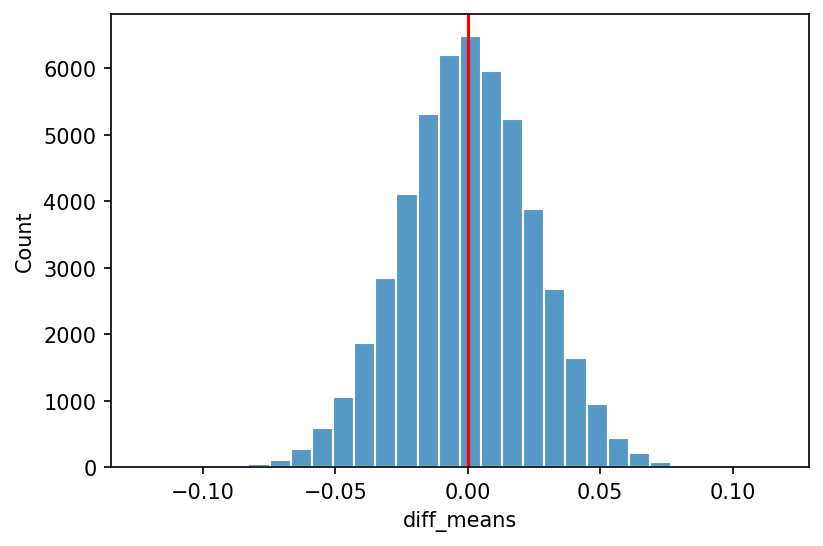

In [42]:
sns.histplot(bootstrap_null_dist.diff_means, bins=30, edgecolor="white");
plt.axvline(0, 0, 1, color="red");

In [43]:
# there's at least one resample where there is true: the original resample
# two-tailed hypothesis test: we're interested in deviations in both directions
p_value = (np.sum(np.where( np.abs(bootstrap_null_dist.diff_means) >= sample_statistic, 1, 0 )) + 1)/ ( 50000 + 1)
p_value

1.999960000799984e-05

The $p$-value is much less than $\alpha = 0.05$, so we feel confident rejecting $H_0$ and accepting $H_a$: there is significant evidence that the mean `scoring` of `tv` and `movie` anime types differs in the population from which the sample was drawn. Note that we're **inferring** this for the population based on a sample.

We could also approach this by calculating a 95% CI of the original sampling distribution, as earlier. If the null value is not inside the CI, we can reject $H_0$ at a significance level of $1-C$, where $C$ is the confidence level. Just a reminder (as we've already done this)

In [44]:
percentile_CI(bootstrap_dist, "diff_means", 0.95)

array([0.34370975, 0.4406005 ])

Zero doesn't fall within the interval, so again we reject $H_0$ and accept $H_a$. The advantage of this is that it gives us a sense of the size of the effect we're investigating. The downside is we don't get a $p$-value.

# Bootstrapping regression

Let's say we're interested in exploring the question

> "In `tv` animes, is there an association between `average_episode_duration` and `scoring`?"

As these are both continuous variables, simple linear regression is an obvious starting point. Let's clean up the columns, drop missing values and have a look at a scatter plot

In [45]:
anime_tv = anime.loc[anime.media_type == "tv", :].dropna(subset=["scoring", "average_episode_duration"])
anime_tv.average_episode_duration

0        0 days 00:24:20
1        0 days 00:23:37
2        0 days 00:24:20
3        0 days 00:24:00
4        0 days 00:23:00
              ...       
23554    0 days 00:07:00
23650    0 days 00:25:00
23740    0 days 00:25:00
23790    0 days 00:24:00
23976    0 days 00:24:20
Name: average_episode_duration, Length: 4175, dtype: object

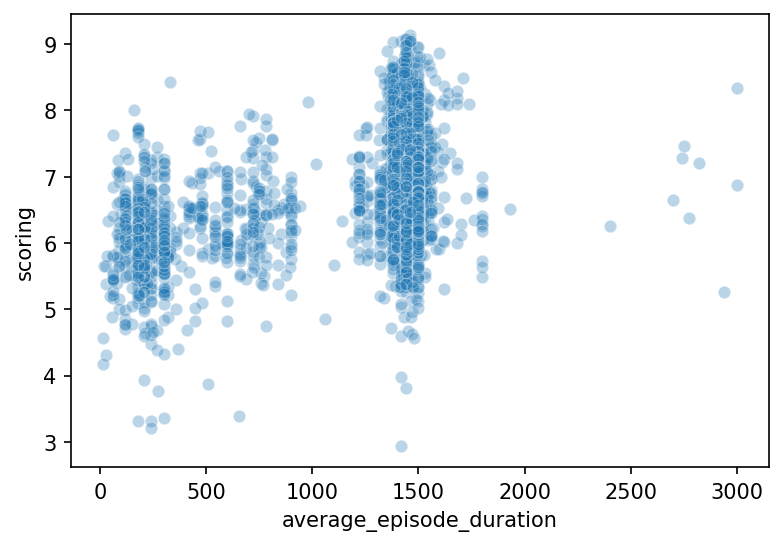

In [46]:
# In original data, average_episode_duration is a string representing an interval.
# Tidy back up to TimeDelta object and then conver to seconds  
anime_tv.average_episode_duration = pd.to_timedelta(anime.average_episode_duration).apply(lambda x: x.total_seconds())
plot = sns.scatterplot(data=anime_tv, x="average_episode_duration", y="scoring", alpha=0.3);

Hmm, we already see evidence of an inhomogeneity of scatter ('heteroskedasticity') of points along any line we care to draw. Let's go on though and have a look at a fitted ordinary least squares (OLS) model.

In [47]:
model = sm.OLS(endog=anime_tv.scoring, exog=sm.add_constant(anime_tv.average_episode_duration)).fit()

In [48]:
# these are the coefficients in y = a * x + c
# c = const, a = average_episode_duration
model.params

const                       5.883561
average_episode_duration    0.000769
dtype: float64

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                scoring   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     786.0
Date:                Tue, 28 Jun 2022   Prob (F-statistic):          1.29e-158
Time:                        22:24:43   Log-Likelihood:                -4606.0
No. Observations:                4175   AIC:                             9216.
Df Residuals:                    4173   BIC:                             9229.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.8836      0.037    159.603      0.000       5.811       5.956
average_episode_duration     0.0008   2.74e-05     28.036      0.000       0.001       0.001
==============================================================================
Omnibus:                       28.627   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.980
Skew:                          -0.055   Prob(JB):                     1.26e-09
Kurtosis:                       3.473   Cond. No.                     4.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We would like to be able to interpret the $t$-statistic and the $p$-value (labelled $P>|t|$) for the `average_episode_duration` coefficient, but we run into a problem. We know that the residuals of the model display heteroskedasticity, and this violates one of the conditions of interpreting the fitting statistics produced by OLS. So what can we do?

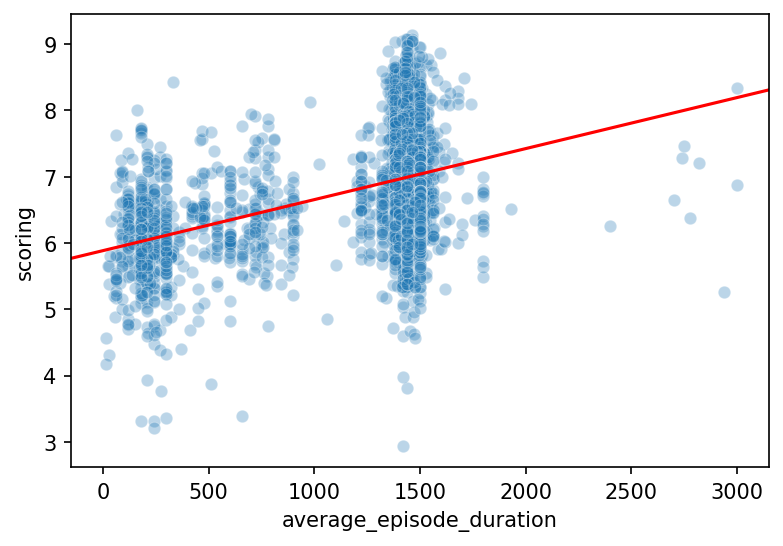

In [50]:
plot = sns.scatterplot(data=anime_tv, x="average_episode_duration", y="scoring", alpha=0.3);
plt.axline(xy1=(0, model.params['const']), slope=model.params['average_episode_duration'], color="red");

We could have a look at confidence intervals for the fitted parameters, but these suffer from the same problem: they make parametric assumptions about the residuals. Note that the choice of model is really up to us, as long as we can justify it: if you want to fit a line, fit a line. But we need to be able to tell whether the fitted parameters are statistically significant, i.e. differ significantly from zero.

In [51]:
model.conf_int(alpha=0.05)

,0,1
const,5.811289,5.955834
average_episode_duration,0.000716,0.000823


If we want to get away from these parametric assumptions, let's try bootstrapping. In this case we randomly resample the original fitting data with replacement, fit a model, and gather the relevant fitted parameters. This gives us a set of sampling distributions we can then use to calculate CIs in the usual way

In [52]:
def bootstrap_simple_linear_regression(sample, x_column, y_column, num_resamples):
    results = []
    for i in range(num_resamples):
        this_resample = sample.sample(sample.shape[0], replace=True)
        this_model = sm.OLS(endog=this_resample[y_column], exog=sm.add_constant(this_resample[x_column])).fit()
        results.append([i + 1, this_model.params["const"], this_model.params[x_column], this_model.rsquared])
    
    return pd.DataFrame(
        data=results, 
        columns=["resample", "const", x_column, "rsquared"]
    )

In [53]:
bootstrap_regression_dists = bootstrap_simple_linear_regression(
    sample=anime_tv, 
    x_column="average_episode_duration", 
    y_column="scoring", 
    num_resamples=10000
)

In [54]:
bootstrap_regression_dists

,resample,const,average_episode_duration,rsquared
0,1,5.840981,0.000798,0.161139
1,2,5.871070,0.000778,0.164742
2,3,5.857998,0.000791,0.168093
3,4,5.835642,0.000817,0.168401
4,5,5.906296,0.000747,0.157874
...,...,...,...,...
9995,9996,5.895516,0.000766,0.161609
9996,9997,5.842554,0.000815,0.169652
9997,9998,5.883489,0.000763,0.161018
9998,9999,5.797160,0.000819,0.169428


In [55]:
percentile_CI(
    bootstrap_dist=bootstrap_regression_dists,
    value_column="average_episode_duration",
    confidence_level=0.95,
)

array([0.00071261, 0.00082712])

In [56]:
bias_corrected_CI(
    bootstrap_dist=bootstrap_regression_dists,
    value_column="average_episode_duration",
    confidence_level=0.95,
    sample_stat=model.params["average_episode_duration"]
)

array([0.00071164, 0.0008257 ])

In [57]:
percentile_CI(
    bootstrap_dist=bootstrap_regression_dists,
    value_column="rsquared",
    confidence_level=0.95,
)

array([0.13750449, 0.18077741])

# More topics to explore

* Permutation tests - a more powerful alternative to bootstrapping in certain situations
* Bootstrap power calculations - for an effect of a given size, how large do your sample(s) need to be to detect it at a desired confidence level?
* Bayesian bootstrap

# Good introductions

* _'Statistical Inference Via Data Science: A ModernDive Into R and the Tidyverse'_ by Kim and Ismay. I recommend this even if you don't know much `R` (`tidyverse` code is pretty self-explanatory TBH), it's very well written, and there's a free version available at https://moderndive.com/
* _'Mathematical Statistics with Resampling and R'_ by Chihara and Hesterberg. Heavy on the maths, but comprehensive
* _'Computer Age Statistical Inference'_ by Efron and Hastie. Again pretty mathematical, but it gets great reviews and one of the authors is the inventor of the bootstrap!

# A future talk: algorithms for bootstrapping big data